# Project 5: Credit Card Customer Segmentation

**Background:** AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster.

**Objective:** Using an unsupervised learning approach, identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

**Key Questions:**

1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What recommendations can be made to improve both customer service and marketing to new customers?

We will tackle this project in several parts:

1. [Import the dataset and libraries](#1)
2. [Perform Exploratory Data Analysis](#2)
3. [Execute K-means Clustering](#3)
4. [Execute Hierarchical Clustering](#4)
5. [Use Silhouette Scores to Compare Methods](#5)
6. [Address the Key Questions using Cluster Analysis](#6)

<a id="1"></a>
### Section 1: Import the dataset and libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib import cm

# configure visualization defaults
plt.style.use('fivethirtyeight')
%matplotlib inline

# ignore warnings
import warnings; warnings.simplefilter('ignore')

# preprocessing helpers
from sklearn.preprocessing import StandardScaler

# cluster models
from sklearn.cluster import KMeans, AgglomerativeClustering

# hierachial clustering helpers
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

# cluster metrics
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# load the data as pandas dataframe
data = pd.read_excel("Credit Card Customer Data.xlsx")

In [3]:
# verify that the data loaded correctly
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
# get the number of rows and columns of the data
print("There are {} rows and {} columns in the dataset.".format(data.shape[0],data.shape[1]))

There are 660 rows and 7 columns in the dataset.


***Description of Features***

| Name                | Description                                      |
|---------------------|--------------------------------------------------|
|Customer key         | Identifier for the customer                      |
|Average Credit Limit | Average credit limit across all the credit cards |
|Total credit cards   | Total number of credit cards                     |
|Total visits bank    | Total number of bank visits                      |
|Total visits online  | Total number of online visits                    |
|Total calls made     | Total number of calls made by the customer       |


Before we dive into EDA portion of the case study, let's first assemble a data quality report.

In [5]:
def data_report(dataframe):
    
    # create numerical data report using built in describe() method
    data_report = dataframe.describe().T
    
    # add a percent missing column
    data_report['% missing'] = dataframe.apply(lambda x: x.isna().mean())
    
    # add a cardinality column
    data_report['cardinality'] = dataframe.apply(lambda x: x.nunique())
    
    # add a skew column
    data_report['skew'] = dataframe.apply(lambda x: x.skew())
    
    # rearrange the columns 
    cols = ['count','% missing','cardinality','mean','std','min','25%','50%','75%','max','skew']
    data_report = data_report[cols]
    
    return data_report

In [6]:
data_report(data)

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
Sl_No,660.0,0.0,660,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0,0.000000
Customer Key,660.0,0.0,655,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0,0.051462
Avg_Credit_Limit,660.0,0.0,110,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0,2.202396
Total_Credit_Cards,660.0,0.0,10,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0,0.144879
Total_visits_bank,660.0,0.0,6,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0,0.141896
Total_visits_online,660.0,0.0,16,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0,2.225607
Total_calls_made,660.0,0.0,11,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0,0.658905


SI_No appears to be an identifier as does Customer Key. There might be duplicate records since the cardinality of Customer Key is 655 and the total number of records is 660.

In [7]:
# checking for duplicates
duplicates = data.duplicated()
data[duplicates].shape[0]

0

Customer Key and SI_No are not informative. We will drop these columns from the data set.

In [8]:
# dropping Sl_No and Customer Key
data.drop(columns=['Sl_No', 'Customer Key'], inplace=True)

<a id="2"></a>
### Section 2: Exploratory Data Analysis
#### 2.1 Univariate Analysis

<b style="color:#2E86C1;font-size:15px;">Avg Credit Limit and Total Credit Cards</b>

In [9]:
data_report(data).loc[['Avg_Credit_Limit','Total_Credit_Cards']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
Avg_Credit_Limit,660.0,0.0,110,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0,2.202396
Total_Credit_Cards,660.0,0.0,10,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0,0.144879


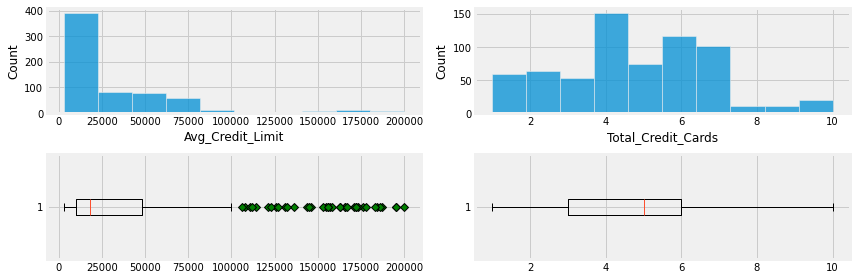

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4), sharex=False)

sns.histplot(data=data, x='Avg_Credit_Limit', bins=10, ax=axes[0,0]);
sns.histplot(data=data, x='Total_Credit_Cards', bins=10, ax=axes[0,1]);
axes[1,0].boxplot(data['Avg_Credit_Limit'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['Total_Credit_Cards'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

**Avg_Credit_Limit** exibits three customer segments. The first, and that which most customers fall into, is those whose average credit limit is between 3k and 20k. Customers who have an average credit limit between 20k and 100k fall into another segement, and finally a third segment which encompasses customers who have an average credit limit above 100k. This last segment contains all of the outliers in this feature. The values for these outliers seem legitimate so we will not be treating them at this time.

**Total_Credit_Cards** is interesting because it exhibits three or even four customer segements:
- customers who have between one and three credit cards,
- customers who have four credit cards,
- customers who have between five and seven credit cards,
- and finally, customers that have more than seven credit cards.

<b style="color:#2E86C1;font-size:15px;">Total Bank and Online Visits</b>

In [11]:
data_report(data).loc[['Total_visits_bank','Total_visits_online']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
Total_visits_bank,660.0,0.0,6,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0,0.141896
Total_visits_online,660.0,0.0,16,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0,2.225607


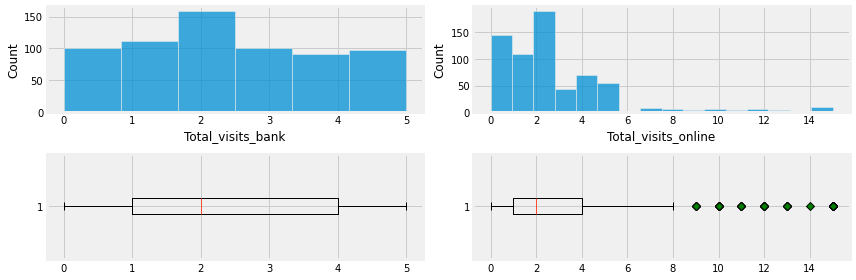

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4), sharex=False)

sns.histplot(data=data, x='Total_visits_bank', bins=6, ax=axes[0,0]);
sns.histplot(data=data, x='Total_visits_online', bins=16, ax=axes[0,1]);
axes[1,0].boxplot(data['Total_visits_bank'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['Total_visits_online'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

**Total_visits_bank** suggests three clusters:
- a uniform distribution consisting of customers who made up to one trip to the bank,
- a another uniform distribution of customers who made three or more trips to the bank, 
- and custormers who visited the bank exactly twice.

**Total_visits_online** also seems to suggest three distinct clusters:
- customers who visited the website between zero and two times,
- customers who visited the website between three and five times,
- and finally, customers who visited more than six times.

This last segment encompasses all of the outliers in this feature, but since these observations all seem valid we will not be treating them at this time.

<b style="color:#2E86C1;font-size:15px;">Total Calls Made</b>

In [13]:
data_report(data).loc[['Total_calls_made']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
Total_calls_made,660.0,0.0,11,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0,0.658905


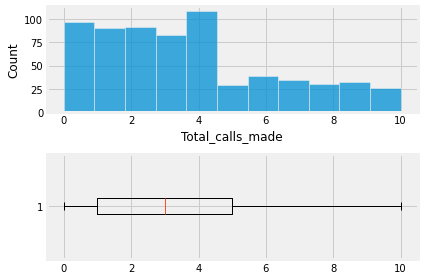

In [14]:
fig, axes = plt.subplots(2, figsize=(6, 4), sharex=False)

sns.histplot(data=data, x='Total_calls_made', bins=11, ax=axes[0]);
axes[1].boxplot(data['Total_calls_made'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));

plt.tight_layout()

**Total_calls_made** we observe two uniform distributions. The first captures those customers who made between zero and four calls to the bank. The second captures those who called more the four times. 

#### 2.1 Bivariate Analysis

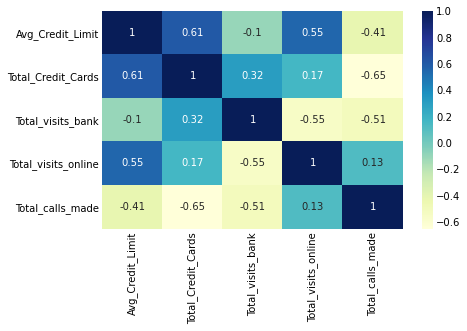

In [15]:
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu');

**Positive Correlations**:
- Customers who have large credit limits tend to have more credit cards.
- Customers with larger credit limits tend to generate more web traffic.

**Negative Correlations**:
- Those customers who have a smaller credit limit tend to call into the bank more often while those with a larger credit limit less so.
- People who utilize the bank's website tend to visit the bank less often.
- Similarly, people who call into the bank tend to visit the bank less frequently

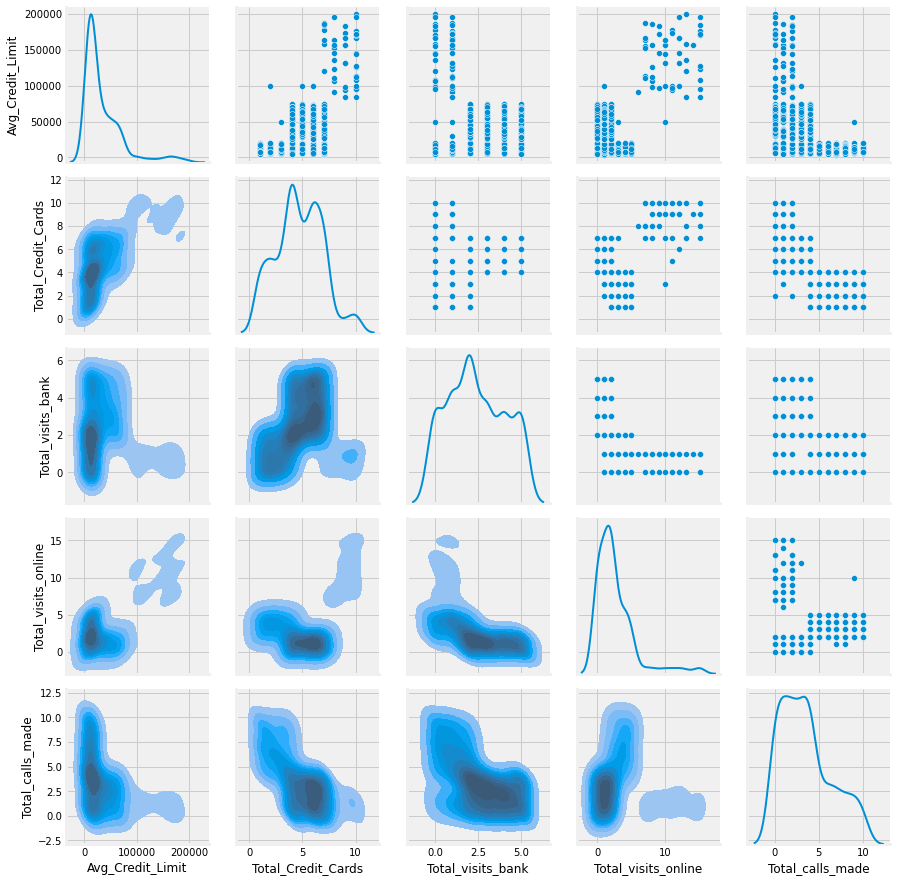

In [16]:
g = sns.PairGrid(data, diag_sharey=False);
g.map_upper(sns.scatterplot);
g.map_lower(sns.kdeplot, fill=True );
g.map_diag(sns.kdeplot,  linewidth=2);

- Looking at the density plot of **total_visits_online** and **Total_Credit_Cards** we observe three distinct clusters: 
    1. A high density cluster of customers who have some where between four and six credit cards and that have made approximately one to two online visits, 
    2. a medium density cluster of customers who have approximately one to three credit cards and who have visited the website around three to five times, and
    3. a low density cluster of customers who have between six and ten credit cards and that have made around six to fifteen online visits.

<a id="3"></a>
### Section 3: K-Means Clustering
K-Means clustering is an extremely intuitive, computationaly efficient, and easy to implement algorithm. It falls into a category of clustering techniques called **prototype-based** where the cluster and its members are represented by a prototype which usually the **centroid** (average) for continuous features or the **mediod** (majority) in the case of categorical features. K-Means clustering is excellent in capturing spherical clusters. 

Before performing clustering, for both K-Means and Hierarchial, we must first scale the data.

#### 3.1 Transform Features using Standard Scaler
The average credit card limit is on a much larger scale than the other features and thus would dominate the clustering analysis. To address this issue we scale our data using a z-score transformation. This transforms our features to have a mean of zero and a standard deviation of one.

In [17]:
# using standard scaler to transform the features to have mean zero and std of one.
std_scaler =StandardScaler()
X = std_scaler.fit_transform(data)

#### 3.2 Using an Elbow Plot to Identify the Optimal Number of Clusters

One of the obstacles in K-Means clustering is that we have to choose the number of clusters a priori, that is we do not know the correct number of clusters before running the algorithm. Fortunately, we have ways of measuring the effectiveness of the segmentation that is obtained for a given number of clusters. One such measure is the within-cluster **sum of squared errors (SSE)** commonly referred to as **distortion** or **inertia**:

\begin{equation*}
SSE = \sum^n_{i=1}\sum^{k}_{j=1}\,{w}^{(i,j)}\|\mathbf{x}^{(i)}-\mathbf{\mu}^{(j)}\|_{2}^{2},
\end{equation*} 

where $\mathbf{\mu}^{(j)}$ is the centroid for cluster *j*, and $w^{(i,j)}$ is given by


\begin{equation*}
{w}^{(i,j)}=\left\{ \begin{array}{lc}
1, & \mbox{if}\: \mathbf{x}^{(i)} \in j\\
0, & \mbox{otherwise}.
\end{array}\right.
\end{equation*}

Given the nature of K-Means, adding a new cluster will always reduce the distortion. However, past a certain number of clusters the distortion will only decrease by a small amount at which point the algorithm is simply capturing noise in the data and not the actual segmentations. To demonstrate this we use a grapichal method called an elbow plot where we calculate the distortion for a range of different values of *k* and then plot the distortions as a function of *k*. 

In [18]:
# calculate the distortions for ten different values of k (k = 1,...,10)
distortions = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, # number of clusters
                n_init=10, # fit the model 10 different times and return the best one in terms of distortion 
                random_state=1)
    km.fit(X)
    distortions.append(km.inertia_)

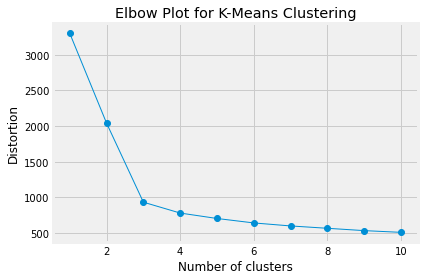

In [19]:
plt.plot(range(1, 11), distortions, marker='o', linewidth=1)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Elbow Plot for K-Means Clustering")
plt.tight_layout()
plt.show()

Based on the elbow plot we conclude that three is the ideal number of clusters using K-Means. Next we refit the model using three clusters and analyze the distribution of the features across the different clusters.

In [20]:
# refit the model using three clusters
kmeans = KMeans(n_clusters=3,random_state=1)

# predict cluster labels
km_clusters = kmeans.fit_predict(X)

# add the cluster labels to the original dataframe
data['km_clusters'] = km_clusters

#### 3.3 Boxplots of the Features across the Clusters

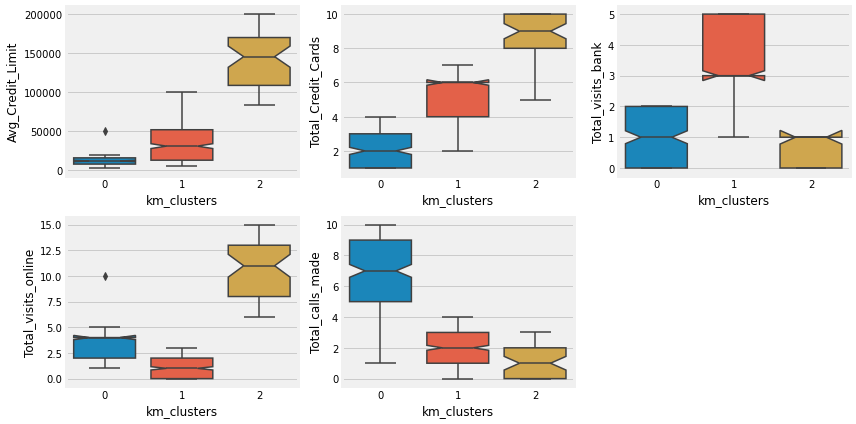

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for idx,feature in enumerate(data.columns[:-1]): 
    ax=axes.flatten()[idx]
    sns.boxplot(data=data, x='km_clusters', y=feature, ax=ax, linewidth=1.5, notch=True);
    
axes[1,2].set_axis_off()
plt.tight_layout()

The K-Means clustering has segmented the data well. We can see a clear separation between the clusters especially for the features Total_Credit_Cards, Total_visits_online, and Avg_Credit_Limit. Some preliminary observations:
1. The first customer segment (shown in blue) has the lowest credit limit and also the least number of credit cards. These customers also make the most number of calls into the bank implying the bank's customer service reps are not resolving issues in a timely manner. Focusing on these customers and their issues would have the largest impact on improving the overall quality of the customer service experience.
2. The third segment (shown in gold) is the bank's high profile customers. These customers have the largest credit limits and also hold the most credit cards. We can also infer from their total number of online visits that this segment accounts for the majority of the bank's web traffic. 

<a id="4"></a>
### Section 4: Hierarchial Clustering
Hierarchial clustering, as the name suggests, attempts to find hierarchies or taxonomies within the data. There are two main strategies that are employed when performing hierarchial clustering. The first strategy is **Agglomerative** which is a "bottom-up" approach where each observation begins as its own cluster, and then pairs of clusters are formed as you ascend the hierarchy. A second less common strategy is **Divisive** which is a "top-down" approach where all observations start in one cluster, and then splits are created recursively as you descend the hierarchy. In this section we will only focus on **Agglomerative** clustering since it is the most common of the two. 

This section will be tackled in five parts. First we introduce the notion of **proximity** and the various distance metrics that will be employed. Second we cover **linkage** which measures the similarity between any two clusters. Third we use the **cophonetic correlation coefficient** to measure the effectiveness of the hierarchial clustering using any particular combination of proximity and linkage measures. After identifying the best proximity and linkage method to use we will visual the cluster hierarchy using a **dendrogram**. Finally, we analyze the resulting clusters using **boxplots**.

#### 4.1 Proximity 
Proximity is the measure of pairwise distance between any two observations in the data set. There are many distance metrics own could use to calculate proximity. Here are the metrics we will be using in this analysis:
- **Chebyshev** (chess board distance),
- **cityblock** (Manhattan distance),
- **correlation**,
- **Euclidean**
- **Jaccard**,
- and **Mahalanobis**.

The mathematical definitions for these metrics can be found in the [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) scipy documention.

#### 4.2 Linkage
Linkage is the manner in which we measure the distances or similarity between two clusters and is a very important parameter for merging clusters and thus building the hierarchy. The following methods are some of the most widely used linkage methods:
- **single** (minimum) linkage measures the distince between the two closest points from one cluster to another,
- **complete** (maximum)  linkage measures the distance between the two farthest points from one cluster to another,
- **average** linkage calculates the pairwise distance between all of the points between the clusters and then averages them, 
- **centroid** linkage calculates the distance from one cluster's centroid to the other 
- and finally **minimum variance** or **Ward's** linkage calculates the average squared pairwise distance.

The mathematical definitions of these methods can be found in the scipy documentation for [linkage.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)

#### 4.3 Cophonetic Correlation Coefficient
Hierarchial clustering is dependent on both the proximity measure and linkage method. One clustering that is perform with a given choice of proximity and linkage measures will not necessary be the same as another clustering that uses a different combination of proximity and linkage. The resulting hierarchies will be different perhaps dramatically so. In light of this, we need a way of comparing the effectiveness between the different hierarchies that are obtained when we change the measures of proximity and linkage. To this end we employ the **cophonetic correlation coefficient**,

\begin{equation*}
c = \frac{\sum_{i<j}(X_{ij}-x)(Z_{ij}-z)}{\sqrt{\sum_{i<j}(X_{ij}-x)^2\sum_{i<j}(Z_{ij}-z)^2}},
\end{equation*} 

where:
- $X_{ij}$ is the proximity between observations *i* and *j* in $X$,
- $Z_{ij}$ is the linkage distance between clusters *i* and *j*,   and
- $x$ and $z$ are the average of $X$ and $Z$, respectively.

The cophonetic correlation takes on values between 0 and 1, where a value close to 1 represents excellent clustering and a faithful representation of the similarities (or dissimilarities) between the observations. 

Now we can compare different hierarchies and choose the best one in terms of the **cophonetic correlation coefficient**. 
We proceed by looping over the different combinations of linkage methods and proximity measures, calculate and store the value of *c*, and then compare the results.

In [22]:
linkage_methods = ['single','complete', 'average', 'centroid', 'ward']
metrics = ['chebyshev', 'cityblock', 'correlation','euclidean', 'jaccard', 'mahalanobis']
coph_dists = np.zeros([5,6])

for i, method in enumerate(linkage_methods):
    for j, metric in enumerate(metrics):
        try:
            Z = linkage(X, metric=metric, method=method)
            coph, coph_mat = cophenet(Z , pdist(X,metric=metric))
            coph_dists[i,j] = coph
        except: # the ward and centroid linkage methods are undefined for all the metrics above except the euclidean metric
            coph_dists[i,j] = 0.0

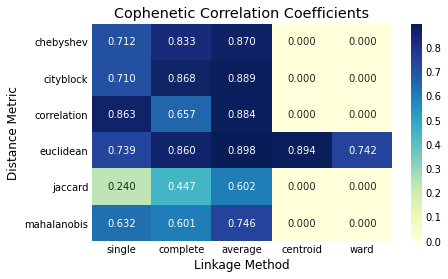

In [23]:
coph_df = pd.DataFrame(coph_dists, index=linkage_methods, columns=metrics).T
sns.heatmap(coph_df,annot=True,  fmt=".3f", cmap="YlGnBu");
plt.xlabel("Linkage Method");
plt.ylabel("Distance Metric");
plt.title("Cophenetic Correlation Coefficients");

The best value of *c* that was obtained was 0.898. This value occured using the *euclidean* metric and the *average* linkage method. The runner up was a *c* of 0.889 using *cityblock* combined with *average*. In the next section we will visualize the dendrograms that result from these two combinations of distance and linkage.

#### 4.3 Dendrogram Visualizations

In [24]:
# recalculate linkage using 'average' as the method and 'euclidean' as the metric
Z = linkage(X, metric='euclidean', method='average')

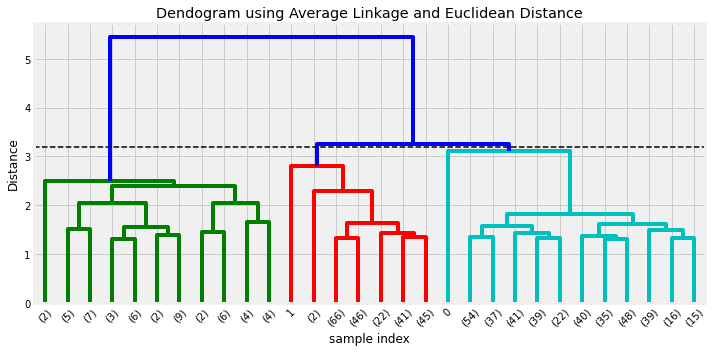

In [25]:
plt.figure(figsize=(10, 5))
threshold=3.2
plt.title('Dendogram using Average Linkage and Euclidean Distance')
plt.xlabel('sample index')
plt.ylabel('Distance')
plt.axhline(y=threshold, color='black', linestyle='--', linewidth=1.5)
dendrogram(Z, color_threshold=threshold, truncate_mode='lastp')
plt.tight_layout()

In [26]:
# recalculate linkage using 'cityblock' as the method and 'euclidean' as the metric
Z = linkage(X, metric='cityblock', method='average')

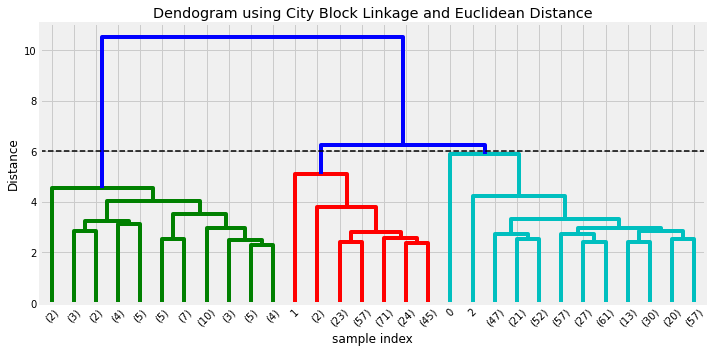

In [27]:
plt.figure(figsize=(10, 5))
threshold=6.0
plt.title('Dendogram using City Block Linkage and Euclidean Distance')
plt.xlabel('sample index')
plt.ylabel('Distance')
plt.axhline(y=threshold, color='black', linestyle='--', linewidth=1.5)
dendrogram(Z, color_threshold=threshold, truncate_mode='lastp')
plt.tight_layout()

Both linkage methods are producing very similar hierarchies. There appears to be three main clusters just like we saw using K-Means. Here we've clipped the above dendrogram at a distance of 6.0. Had we used a shorter distance, say a distance of 5.8, then we would have obtained four clusters. However, the fourth cluster would only contain one customer (sample index 0).

#### 4.5 Analyzing the Clusters using Boxplots

Using the dendrograms we were able to see that the ideal number of clusters was three. Now we use Sklearn's [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) to perform the hierarchial clustering in just a few lines of code. Once that is complete we analyse the resulting clusters using boxplots.

In [28]:
# create hierachial clustering using 3 clusters
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', # this is our proximity measure
                             linkage='average' # using the average linkage method
                            )

# predict cluster labels
ac_clusters = ac.fit_predict(X)

# add the cluster labels to the original dataframe
data['ac_clusters'] = ac_clusters

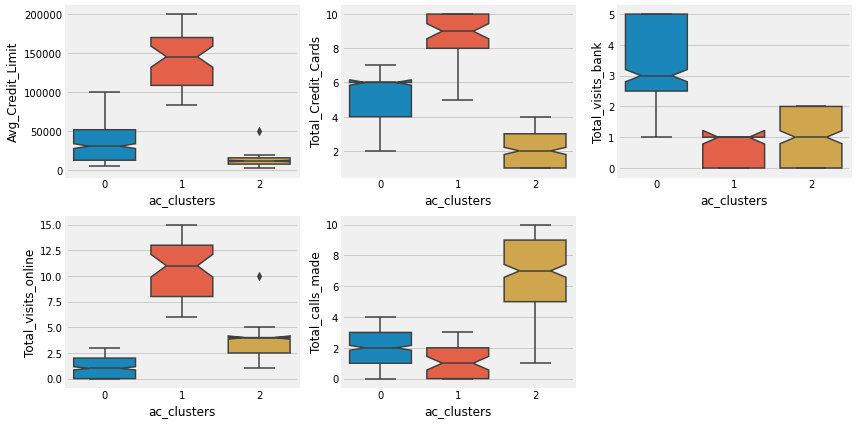

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for idx,feature in enumerate(data.columns[:5]): 
    ax=axes.flatten()[idx]
    sns.boxplot(data=data, x='ac_clusters', y=feature, ax=ax, linewidth=1.5, notch=True);
    
axes[1,2].set_axis_off()
plt.tight_layout()

These results are very similar to those obtained using K-Means: 
- The gold cluster contains the customers with the smallest number of credit cards and the lowest credit limit while still being the customers who call into the bank most frequently. 
- The red cluster is the high profile customers who have the largest credit limits, own the most credit cards, are the most frequent visitors to the website, and call into customer service the least.
- The blue cluster sits some where between the other two. The main distinction for these customers is that they visit the bank more than any other segment.

<a id="5"></a>
### Section 5: Silhouette Scores and the Comparison of Cluster Methods

Another metric at our disposal for judging the quality of the clustering is the **silhouette** score. This score is calculated for every observation and the values can range from -1 to 1, where a value of 1 implies the observation is very similar to the other observations within its cluster and very dissimilar to observations outside of its cluster. On the other hand a score close to -1 implies that the observation is more similar to observations outside of its cluster than to those within its cluster. 

The silhouette score is calculated in three parts: 
1. For any observation $i$ in cluster $C_{i}$, define the **cluster cohesion** as  

\begin{equation*}
a(i)=\frac{1}{|C_{i}|-1}\sum_{j \in C_{i}, i \neq j}d(i,j).
\end{equation*}

2. For each observation $i$ in cluster $C_{i}$, define the **cluster separation** as

\begin{equation*}
b(i)=\min_{k \neq i}\frac{1}{|C_{i}|}\sum_{j \in C_{k}}d(i,j).
\end{equation*}

3. Now the **silhouette score** of observation $i$ is

\begin{equation*}
{s}^{(i)}=\left\{ \begin{array}{lc}
1-a(i)/b(i), & \mbox{if}\: a(i)<b(i)\\
0, & \mbox{if}\: a(i)=b(i) \\
b(i)/a(i)-1, & \mbox{if}\: a(i)>b(i)
\end{array}\right.
\end{equation*}

To summarize how well the clustering performed we can take the mean of all the silhouette score. Once that is complete we can make our comparisons. That is what we will do in the next section.

#### 5.1 Mean Silhouette Scores

In [30]:
s_scores = np.zeros([5,2])
clusters = np.arange(2,7)

for i, k in enumerate(clusters):
    
    # perform K-Means clustering using k clusters
    km = KMeans(n_clusters=k, n_init=10, random_state=1)
    y_km = km.fit_predict(X)
    
    # record mean silhouette score for K-Means
    silhouette_scores = silhouette_samples(X, y_km, metric='euclidean')
    s_scores[i,0] = np.mean(silhouette_scores)
    
    # perform hierarchial clustering using k clusters
    ac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='average')
    y_ac = ac.fit_predict(X)
    
    # record mean silhouette score for hierarchial clustering
    silhouette_scores = silhouette_samples(X, y_ac, metric='euclidean')
    s_scores[i,1] = np.mean(silhouette_scores)

Below are the mean silhouette scores for both hieracrchial and K-Means clustering using two to six clusters.

In [31]:
pd.DataFrame(s_scores, index=["{} clusters".format(k) for k in clusters], columns=['K-Means','Hierarchial'])

,K-Means,Hierarchial
2 clusters,0.418425,0.570318
3 clusters,0.515718,0.515922
4 clusters,0.355667,0.474951
5 clusters,0.272514,0.440398
6 clusters,0.255450,0.415355


Similar to what we saw in the elbow plot above, the ideal number of clusters for K-Means is three. Something interesting occurs for hierarchial clustering. All of our analysis has shown that the correct number of clusters for this data is three. However, based on the silhouette score, it appears the ideal number is two when using hierarchial clustering and not three. The fact that we know the ideal number is three and that the silhouette score decreases when moving from two to three clusters could suggest that K-Means is more suited for this data set, though the silhouette scores are pretty much the same at three clusters.

We can also visualize the silhouette scores.

In [32]:
def silhouette(clusters,ax):
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, clusters, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.viridis(float(i) / n_clusters)
        ax.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    ax.axvline(silhouette_avg, color="red", linestyle="--", linewidth=1.5) 

    ax.set_yticks(yticks)
    ax.set_yticklabels(cluster_labels + 1)
    ax.set_ylabel('Cluster')
    ax.set_xlabel('Silhouette coefficient')

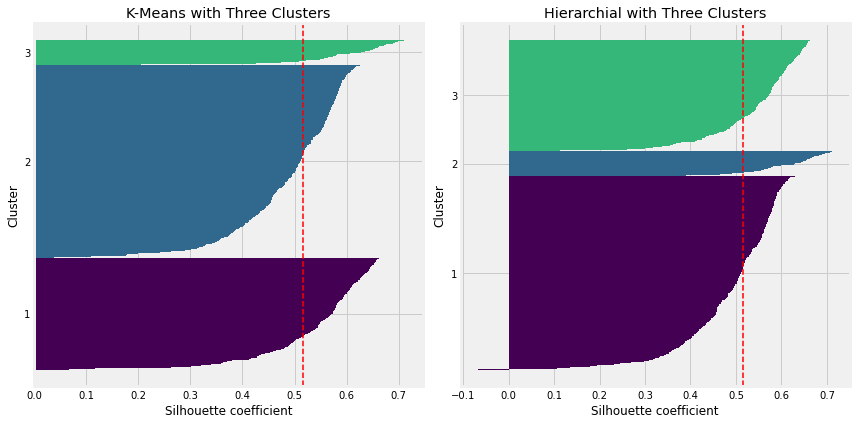

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

silhouette(km_clusters,ax1);
silhouette(ac_clusters,ax2);
ax1.set_title("K-Means with Three Clusters");
ax2.set_title("Hierarchial with Three Clusters");
plt.tight_layout()

A visual inspection for the plots reveals several insights:
- The width of the cluster indicates the number of observations contained within. For K-Means cluster 2 contains the most observations
- The smallest cluster, cluster 3, has the best silhouette scores. The smallest score is around 0.2 while the largest is about 0.71. This indicates that the members of this cluster are very similar to one another and quite dissimilar to members outside of this cluster.
- Hierarchial cluster 1 has a score that is negative. This indicates there is a member of this cluster that is more similar to members outside of its cluster
- The scores and sizes of the clusters are very similar across both methods. Note the average silhouette score, shown as the red dotted line, is approximately the same for both. 

<a id="6"></a>
### Section 6: Conclusions